In [1]:
from envs.doom_env import DoomEnv

# Initializing environment
env = DoomEnv('vizdoom/scenarios/basic.cfg', True)

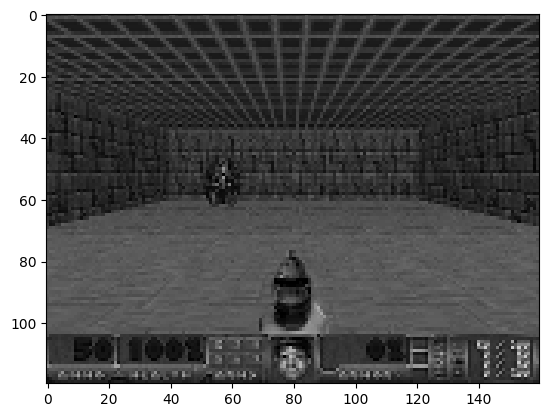

In [2]:
from matplotlib import pyplot as plt
import cv2

frame = env.reset();
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [3]:
observation_shape = env.game.get_state().screen_buffer.shape
print(observation_shape / 2)
# observation_shape = observation_shape[1:] + (1, )
# print(observation_shape)

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'

In [4]:
from agents.ppo_agent import PpoAgent

# Creating ppo agent
agent = PpoAgent(env=env, training_epochs=4, learning_rate=7e-3)

# Initializing training variables
training_batch_size = 300
number_of_games = 20000

num_learning_iterations = 0
best_score = 0
score_history = []

creating actor network...
Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

successfully created actor network!
creating critic network...


successfully created critic network!
creating optimizer for actor network...
successfully created optimizer for actor network!
creating optimizer for critic network...
successfully created optimizer for critic network!


In [5]:
import numpy as np

for i in range(number_of_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action, probabilities, val = agent.get_optimal_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.remember_experience(observation, action, probabilities, val, reward, done)
        
        if agent.num_of_experiences() >= training_batch_size or done:
            agent.try_learning_from_experience(training_batch_size)
            num_learning_iterations += 1

        observation = observation_

    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    agent.memory.clear()

    print('episode', i, 'score %.1f' % score, 'best_score %.1f' % best_score, 'avg_score %.1f' % avg_score,
          'time_steps', training_batch_size, 'learning_steps', num_learning_iterations)

saving models ...


INFO:tensorflow:Assets written to: models/actor_1684498594426/assets


INFO:tensorflow:Assets written to: models/actor_1684498594426/assets


INFO:tensorflow:Assets written to: models/critic_1684498595079/assets


INFO:tensorflow:Assets written to: models/critic_1684498595079/assets


successfully saved models!
episode 0 score 75.0 best_score 75.0 avg_score 75.0 time_steps 300 learning_steps 1
saving models ...


INFO:tensorflow:Assets written to: models/actor_1684498596946/assets


INFO:tensorflow:Assets written to: models/actor_1684498596946/assets


INFO:tensorflow:Assets written to: models/critic_1684498597513/assets


INFO:tensorflow:Assets written to: models/critic_1684498597513/assets


successfully saved models!
episode 1 score 95.0 best_score 85.0 avg_score 85.0 time_steps 300 learning_steps 2
saving models ...


INFO:tensorflow:Assets written to: models/actor_1684498598525/assets


INFO:tensorflow:Assets written to: models/actor_1684498598525/assets


INFO:tensorflow:Assets written to: models/critic_1684498599086/assets


INFO:tensorflow:Assets written to: models/critic_1684498599086/assets


successfully saved models!
episode 2 score 95.0 best_score 88.3 avg_score 88.3 time_steps 300 learning_steps 3
episode 3 score -390.0 best_score 88.3 avg_score -31.2 time_steps 300 learning_steps 4
episode 4 score 53.0 best_score 88.3 avg_score -14.4 time_steps 300 learning_steps 5
episode 5 score 37.0 best_score 88.3 avg_score -5.8 time_steps 300 learning_steps 6
episode 6 score -395.0 best_score 88.3 avg_score -61.4 time_steps 300 learning_steps 7
episode 7 score 51.0 best_score 88.3 avg_score -47.4 time_steps 300 learning_steps 8
episode 8 score -395.0 best_score 88.3 avg_score -86.0 time_steps 300 learning_steps 9
episode 9 score -385.0 best_score 88.3 avg_score -115.9 time_steps 300 learning_steps 10
episode 10 score -114.0 best_score 88.3 avg_score -115.7 time_steps 300 learning_steps 11
episode 11 score -68.0 best_score 88.3 avg_score -111.8 time_steps 300 learning_steps 12
episode 12 score 5.0 best_score 88.3 avg_score -102.8 time_steps 300 learning_steps 13
episode 13 score -9

In [ ]:
# Saving models
agent.save_models()

In [3]:
env.close()